In [1]:
import os
from glob import glob
import time, gc

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import cv2
import tensorflow
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

In [2]:
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input\bengaliai-cv19\class_map.csv
../input\bengaliai-cv19\class_map_corrected.csv
../input\bengaliai-cv19\sample_submission.csv
../input\bengaliai-cv19\test.csv
../input\bengaliai-cv19\test_image_data_0.parquet
../input\bengaliai-cv19\test_image_data_1.parquet
../input\bengaliai-cv19\test_image_data_2.parquet
../input\bengaliai-cv19\test_image_data_3.parquet
../input\bengaliai-cv19\train.csv
../input\bengaliai-cv19\train_image_data_0.parquet
../input\bengaliai-cv19\train_image_data_1.parquet
../input\bengaliai-cv19\train_image_data_2.parquet
../input\bengaliai-cv19\train_image_data_3.parquet
../input\bengaliai-cv19\train_multi_diacritics.csv
../input\kalpurush-fonts\kalpurush-2.ttf
../input\sample-images\sample-0-0.png
../input\sample-images\sample-0-1.png
../input\sample-images\sample-0-2.png
../input\sample-images\sample-1-0.png
../input\sample-images\sample-1-1.png
../input\sample-images\sample-1-2.png
../input\sample-images\sample-2-0.png
../input\sample-images\sample-2-1.png
.

In [3]:
train_df_ = pd.read_csv('../input/bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('../input/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('../input/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('../input/bengaliai-cv19/sample_submission.csv')

In [4]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [5]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [6]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [7]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [8]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [9]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('../input/kalpurush-fonts/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

In [10]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


In [11]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


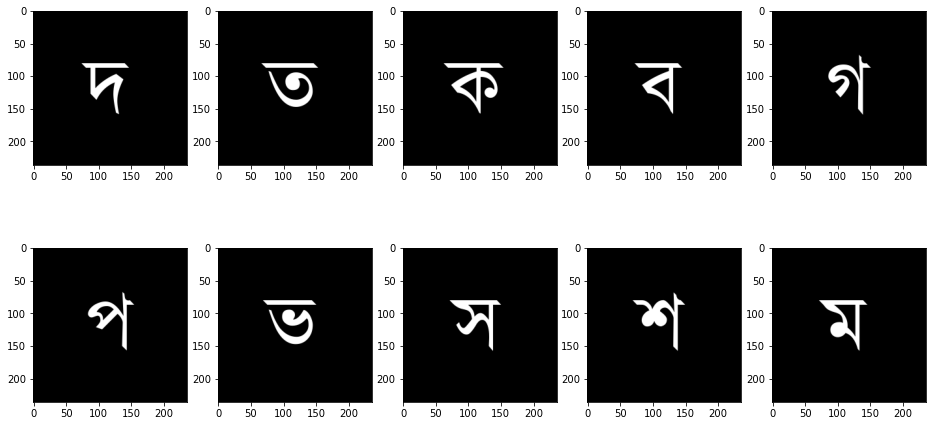

In [12]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

In [13]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


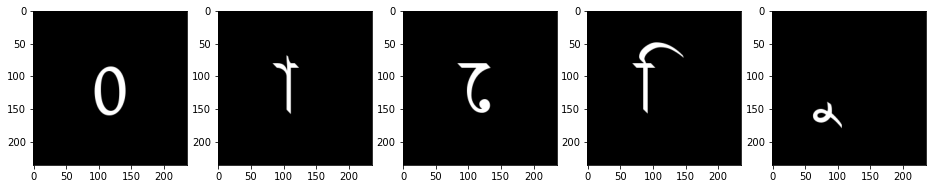

In [14]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

In [15]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


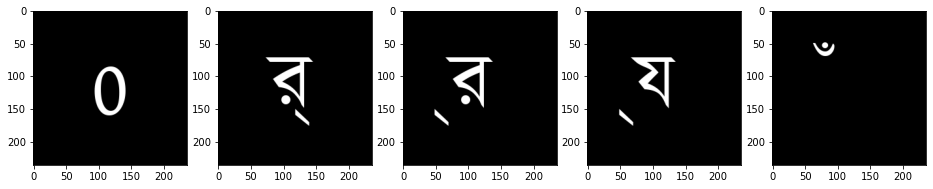

In [16]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='Greys')

In [17]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [18]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [19]:
IMG_SIZE=64
N_CHANNELS=1

In [20]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [21]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [45]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_21[0][0]                  
____________________________________________________________________________________________

In [24]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
batch_size = 256
epochs = 30

In [28]:
class MultiOutputDataGenerator(tensorflow.keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [29]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    "../model" ,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
)

In [30]:
HEIGHT = 137
WIDTH = 236

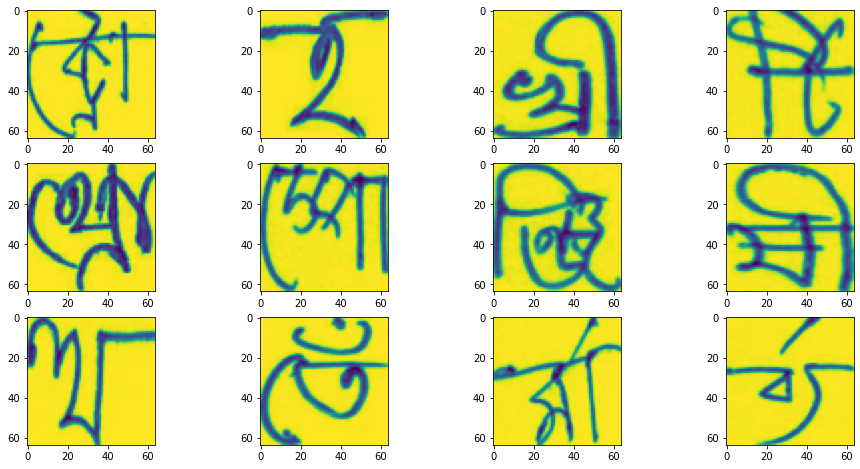

  0%|          | 0/50210 [00:00<?, ?it/s]

Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Instructions for updating:
Please use Model.fit, which supports generators.
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
179/180 [============================>.] - ETA: 0s - loss: 7.8651 - dense_2_loss: 4.7407 - dense_3_loss: 1.9229 - dense_4_loss: 1.2015 - dense_2_accuracy: 0.0290 - dense_3_accuracy: 0.3245 - dense_4_accuracy: 0.6177WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
Instructions for updating:
If using Keras pass *_constraint argument

Epoch 8/30
179/180 [============================>.] - ETA: 0s - loss: 2.8005 - dense_2_loss: 1.9173 - dense_3_loss: 0.5231 - dense_4_loss: 0.3602 - dense_2_accuracy: 0.4495 - dense_3_accuracy: 0.8349 - dense_4_accuracy: 0.8844WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 139s 772ms/step - loss: 2.7997 - dense_2_loss: 1.9163 - dense_3_loss: 0.5234 - dense_4_loss: 0.3600 - dense_2_accuracy: 0.4496 - dense_3_accuracy: 0.8349 - dense_4_accuracy: 0.8845 - val_loss: 1.8291 - val_dense_2_loss: 1.3376 - val_dense_3_loss: 0.2598 - val_dense_4_loss: 0.2327 - val_dense_2_accuracy: 0.6069 - val_dense_3_accur

Epoch 16/30
179/180 [============================>.] - ETA: 0s - loss: 1.2457 - dense_2_loss: 0.7377 - dense_3_loss: 0.3022 - dense_4_loss: 0.2059 - dense_2_accuracy: 0.7872 - dense_3_accuracy: 0.9095 - dense_4_accuracy: 0.9362WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 138s 767ms/step - loss: 1.2455 - dense_2_loss: 0.7374 - dense_3_loss: 0.3021 - dense_4_loss: 0.2060 - dense_2_accuracy: 0.7872 - dense_3_accuracy: 0.9097 - dense_4_accuracy: 0.9362 - val_loss: 0.7941 - val_dense_2_loss: 0.5182 - val_dense_3_loss: 0.1533 - val_dense_4_loss: 0.1259 - val_dense_2_accuracy: 0.8526 - val_dense_3_accu

Epoch 24/30
179/180 [============================>.] - ETA: 0s - loss: 0.8831 - dense_2_loss: 0.4999 - dense_3_loss: 0.2299 - dense_4_loss: 0.1533 - dense_2_accuracy: 0.8547 - dense_3_accuracy: 0.9326 - dense_4_accuracy: 0.9526WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 138s 764ms/step - loss: 0.8833 - dense_2_loss: 0.4999 - dense_3_loss: 0.2302 - dense_4_loss: 0.1532 - dense_2_accuracy: 0.8546 - dense_3_accuracy: 0.9325 - dense_4_accuracy: 0.9526 - val_loss: 0.5859 - val_dense_2_loss: 0.3905 - val_dense_3_loss: 0.1032 - val_dense_4_loss: 0.0939 - val_dense_2_accuracy: 0.8964 - val_dense_3_accu

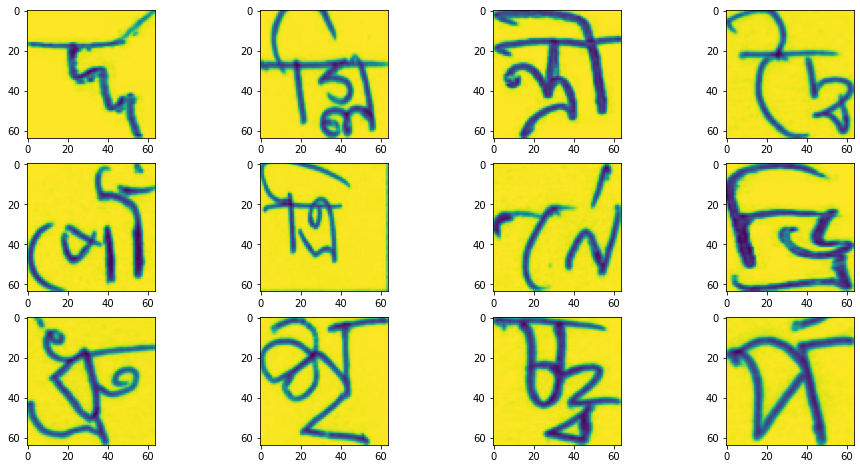

  0%|          | 0/50210 [00:00<?, ?it/s]

Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 118s 656ms/step - loss: 1.0043 - dense_2_loss: 0.5877 - dense_3_loss: 0.2454 - dense_4_loss: 0.1711 - dense_2_accuracy: 0.8402 - dense_3_accuracy: 0.9303 - dense_4_accuracy: 0.9490 - val_loss: 0.5493 - val_dense_2_loss: 0.3396 - val_dense_3_loss: 0.1127 - val_dense_4_loss: 0.0941 - val_dense_2_accuracy: 0.9042 - val_dense_3_accuracy: 0.9706 - val_dense_4_accuracy: 0.9729
Epoch 2/30
179/180 [============================>.] - ETA: 0s - loss: 0.9143 - dense_2_loss: 0.5245 - dense_3_loss: 0.2311 - dense_4_loss: 0.1588 - dense_2_accuracy: 0.8538 - dense_3_accuracy: 0.9347 - dense_4_accuracy: 0.9533WARNING:tensorflow:Reduce LR on plateau conditioned on metric `de

Epoch 9/30
179/180 [============================>.] - ETA: 0s - loss: 0.6802 - dense_2_loss: 0.3768 - dense_3_loss: 0.1800 - dense_4_loss: 0.1233 - dense_2_accuracy: 0.8900 - dense_3_accuracy: 0.9481 - dense_4_accuracy: 0.9623WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 140s 779ms/step - loss: 0.6804 - dense_2_loss: 0.3767 - dense_3_loss: 0.1803 - dense_4_loss: 0.1233 - dense_2_accuracy: 0.8899 - dense_3_accuracy: 0.9480 - dense_4_accuracy: 0.9623 - val_loss: 0.4569 - val_dense_2_loss: 0.2819 - val_dense_3_loss: 0.0987 - val_dense_4_loss: 0.0751 - val_dense_2_accuracy: 0.9223 - val_dense_3_accur

179/180 [============================>.] - ETA: 0s - loss: 0.3999 - dense_2_loss: 0.2011 - dense_3_loss: 0.1197 - dense_4_loss: 0.0791 - dense_2_accuracy: 0.9383 - dense_3_accuracy: 0.9658 - dense_4_accuracy: 0.9757WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 142s 789ms/step - loss: 0.3992 - dense_2_loss: 0.2005 - dense_3_loss: 0.1199 - dense_4_loss: 0.0787 - dense_2_accuracy: 0.9385 - dense_3_accuracy: 0.9656 - dense_4_accuracy: 0.9758 - val_loss: 0.4059 - val_dense_2_loss: 0.2518 - val_dense_3_loss: 0.0857 - val_dense_4_loss: 0.0687 - val_dense_2_accuracy: 0.9358 - val_dense_3_accuracy: 0.9806

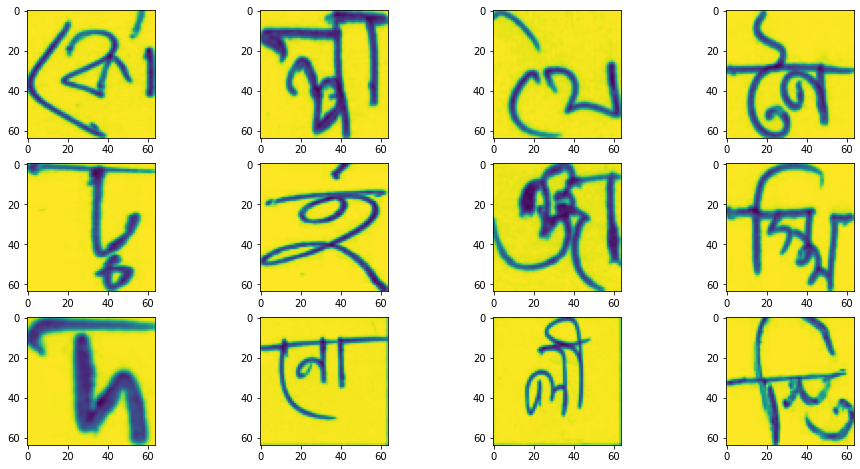

  0%|          | 0/50210 [00:00<?, ?it/s]

Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
179/180 [============================>.] - ETA: 0s - loss: 0.6683 - dense_2_loss: 0.3876 - dense_3_loss: 0.1614 - dense_4_loss: 0.1193 - dense_2_accuracy: 0.8970 - dense_3_accuracy: 0.9545 - dense_4_accuracy: 0.9643WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 132s 732ms/step - loss: 0.6690 - dense_2_loss: 0.3

Epoch 9/30
180/180 [==============================] - 129s 716ms/step - loss: 0.4320 - dense_2_loss: 0.2291 - dense_3_loss: 0.1210 - dense_4_loss: 0.0819 - dense_2_accuracy: 0.9318 - dense_3_accuracy: 0.9639 - dense_4_accuracy: 0.9750 - val_loss: 0.3652 - val_dense_2_loss: 0.2275 - val_dense_3_loss: 0.0667 - val_dense_4_loss: 0.0735 - val_dense_2_accuracy: 0.9445 - val_dense_3_accuracy: 0.9831 - val_dense_4_accuracy: 0.9783
Epoch 10/30
180/180 [==============================] - 130s 722ms/step - loss: 0.4237 - dense_2_loss: 0.2232 - dense_3_loss: 0.1211 - dense_4_loss: 0.0794 - dense_2_accuracy: 0.9326 - dense_3_accuracy: 0.9651 - dense_4_accuracy: 0.9758 - val_loss: 0.3769 - val_dense_2_loss: 0.2292 - val_dense_3_loss: 0.0771 - val_dense_4_loss: 0.0732 - val_dense_2_accuracy: 0.9425 - val_dense_3_accuracy: 0.9796 - val_dense_4_accuracy: 0.9806
Epoch 11/30
180/180 [==============================] - 130s 721ms/step - loss: 0.4128 - dense_2_loss: 0.2195 - dense_3_loss: 0.1148 - dense_4_l

180/180 [==============================] - 129s 718ms/step - loss: 0.3649 - dense_2_loss: 0.1855 - dense_3_loss: 0.1072 - dense_4_loss: 0.0722 - dense_2_accuracy: 0.9432 - dense_3_accuracy: 0.9687 - dense_4_accuracy: 0.9784 - val_loss: 0.3927 - val_dense_2_loss: 0.2444 - val_dense_3_loss: 0.0713 - val_dense_4_loss: 0.0794 - val_dense_2_accuracy: 0.9435 - val_dense_3_accuracy: 0.9841 - val_dense_4_accuracy: 0.9783
Epoch 18/30
180/180 [==============================] - 129s 717ms/step - loss: 0.3623 - dense_2_loss: 0.1855 - dense_3_loss: 0.1042 - dense_4_loss: 0.0727 - dense_2_accuracy: 0.9446 - dense_3_accuracy: 0.9696 - dense_4_accuracy: 0.9779 - val_loss: 0.3780 - val_dense_2_loss: 0.2332 - val_dense_3_loss: 0.0714 - val_dense_4_loss: 0.0771 - val_dense_2_accuracy: 0.9425 - val_dense_3_accuracy: 0.9831 - val_dense_4_accuracy: 0.9791
Epoch 19/30
180/180 [==============================] - 129s 718ms/step - loss: 0.3516 - dense_2_loss: 0.1735 - dense_3_loss: 0.1100 - dense_4_loss: 0.0682

Epoch 26/30
180/180 [==============================] - 132s 731ms/step - loss: 0.2468 - dense_2_loss: 0.1170 - dense_3_loss: 0.0796 - dense_4_loss: 0.0503 - dense_2_accuracy: 0.9635 - dense_3_accuracy: 0.9764 - dense_4_accuracy: 0.9848 - val_loss: 0.3651 - val_dense_2_loss: 0.2241 - val_dense_3_loss: 0.0685 - val_dense_4_loss: 0.0760 - val_dense_2_accuracy: 0.9500 - val_dense_3_accuracy: 0.9816 - val_dense_4_accuracy: 0.9796
Epoch 27/30
180/180 [==============================] - 130s 722ms/step - loss: 0.2431 - dense_2_loss: 0.1150 - dense_3_loss: 0.0788 - dense_4_loss: 0.0494 - dense_2_accuracy: 0.9645 - dense_3_accuracy: 0.9763 - dense_4_accuracy: 0.9849 - val_loss: 0.3602 - val_dense_2_loss: 0.2239 - val_dense_3_loss: 0.0708 - val_dense_4_loss: 0.0710 - val_dense_2_accuracy: 0.9522 - val_dense_3_accuracy: 0.9818 - val_dense_4_accuracy: 0.9816
Epoch 28/30
180/180 [==============================] - 130s 722ms/step - loss: 0.2403 - dense_2_loss: 0.1117 - dense_3_loss: 0.0804 - dense_4_

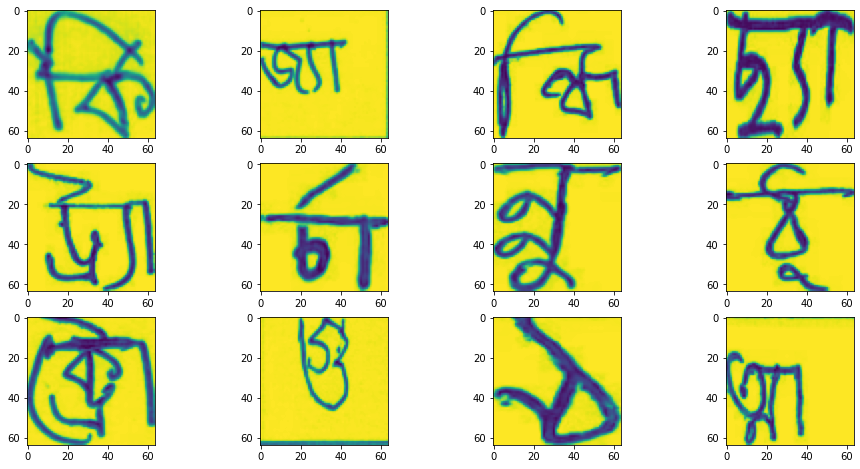

  0%|          | 0/50210 [00:00<?, ?it/s]

Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
179/180 [============================>.] - ETA: 0s - loss: 0.5480 - dense_2_loss: 0.3169 - dense_3_loss: 0.1364 - dense_4_loss: 0.0948 - dense_2_accuracy: 0.9188 - dense_3_accuracy: 0.9621 - dense_4_accuracy: 0.9731WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 131s 729ms/step - loss: 0.5483 - dense_2_loss: 0.3

Epoch 9/30
180/180 [==============================] - 129s 718ms/step - loss: 0.4270 - dense_2_loss: 0.2342 - dense_3_loss: 0.1117 - dense_4_loss: 0.0811 - dense_2_accuracy: 0.9335 - dense_3_accuracy: 0.9675 - dense_4_accuracy: 0.9763 - val_loss: 0.2803 - val_dense_2_loss: 0.1734 - val_dense_3_loss: 0.0595 - val_dense_4_loss: 0.0465 - val_dense_2_accuracy: 0.9520 - val_dense_3_accuracy: 0.9848 - val_dense_4_accuracy: 0.9878
Epoch 10/30
179/180 [============================>.] - ETA: 0s - loss: 0.4136 - dense_2_loss: 0.2277 - dense_3_loss: 0.1089 - dense_4_loss: 0.0771 - dense_2_accuracy: 0.9365 - dense_3_accuracy: 0.9683 - dense_4_accuracy: 0.9766
Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
INFO:tensorflow:Assets written to: ../model\assets
180/180 [==============================] - 142s 791ms/step - loss: 0.4134 - dense_2_loss: 0.2275 - dense_3_loss: 0.1090 - dense_4_loss: 0.0769 - dense_2_accuracy: 0.9366 - dense_3_accuracy: 0.9682 - dense_4_accura

Epoch 17/30
180/180 [==============================] - 131s 729ms/step - loss: 0.3898 - dense_2_loss: 0.2111 - dense_3_loss: 0.1062 - dense_4_loss: 0.0726 - dense_2_accuracy: 0.9371 - dense_3_accuracy: 0.9688 - dense_4_accuracy: 0.9775 - val_loss: 0.2726 - val_dense_2_loss: 0.1696 - val_dense_3_loss: 0.0585 - val_dense_4_loss: 0.0438 - val_dense_2_accuracy: 0.9529 - val_dense_3_accuracy: 0.9863 - val_dense_4_accuracy: 0.9890
Epoch 18/30
180/180 [==============================] - 131s 727ms/step - loss: 0.3903 - dense_2_loss: 0.2111 - dense_3_loss: 0.1047 - dense_4_loss: 0.0744 - dense_2_accuracy: 0.9386 - dense_3_accuracy: 0.9697 - dense_4_accuracy: 0.9783 - val_loss: 0.2809 - val_dense_2_loss: 0.1722 - val_dense_3_loss: 0.0615 - val_dense_4_loss: 0.0462 - val_dense_2_accuracy: 0.9512 - val_dense_3_accuracy: 0.9846 - val_dense_4_accuracy: 0.9871
Epoch 19/30
180/180 [==============================] - 130s 723ms/step - loss: 0.3827 - dense_2_loss: 0.2078 - dense_3_loss: 0.1055 - dense_4_

180/180 [==============================] - 131s 726ms/step - loss: 0.3741 - dense_2_loss: 0.2033 - dense_3_loss: 0.1004 - dense_4_loss: 0.0704 - dense_2_accuracy: 0.9410 - dense_3_accuracy: 0.9705 - dense_4_accuracy: 0.9791 - val_loss: 0.2720 - val_dense_2_loss: 0.1668 - val_dense_3_loss: 0.0586 - val_dense_4_loss: 0.0457 - val_dense_2_accuracy: 0.9534 - val_dense_3_accuracy: 0.9861 - val_dense_4_accuracy: 0.9881
Epoch 26/30
179/180 [============================>.] - ETA: 0s - loss: 0.3824 - dense_2_loss: 0.2067 - dense_3_loss: 0.1035 - dense_4_loss: 0.0723 - dense_2_accuracy: 0.9397 - dense_3_accuracy: 0.9693 - dense_4_accuracy: 0.9780WARNING:tensorflow:Reduce LR on plateau conditioned on metric `dense_5_accuracy` which is not available. Available metrics are: loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,lr
INFO:te

In [32]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'../input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, 
                                                                                                                                    Y_train_root, 
                                                                                                                                    Y_train_vowel, 
                                                                                                                                    Y_train_consonant, 
                                                                                                                                    test_size=0.08, 
                                                                                                                                    random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_2': y_train_root, 'dense_3': y_train_vowel, 'dense_4': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant, model_checkpoint_callback])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [49]:
model.save('../model/my_model')

INFO:tensorflow:Assets written to: ../model/my_model\assets


In [50]:
new_model = tensorflow.keras.models.load_model('../model/my_model')

In [51]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_21[0][0]                  
____________________________________________________________________________________________